# Dynamic U-Net based Semantic Segmentation for Building Extraction from Satellite and Aerial Imagery


## About
### Author: Chintan Bimal Maniyar (M.Tech, PRSD)
### Dated: Dec 4, 2020
### Execution Details: 
* OS - *Windows 10*
* Environment - *Python 3.6.4* in *conda*
* Framework - *fastai 1.0.61* wrapped on *Pytorch 1.5.0*  
* GPU Support - *Cuda 10.2* on * NVIDIA GeForce GTX 1050*

### Detials:
This notebook explores the semantic segmentation of buildings using a Dyanmic U-Net architecture.
The model is trained on 8716 tiles from the following four sources of data:
    1. [OpenAI Mapping Challenge](https://competitions.codalab.org/competitions/20100)
    2. [SpaceNet Building Detectors](https://registry.opendata.aws/spacenet/)
    3. [Massachuesets Building Dataset](https://www.kaggle.com/balraj98/massachusetts-buildings-dataset)
    4. [Inria Building Dataset](https://project.inria.fr/aerialimagelabeling/)

## 0. Configuring Environment

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# UNSAFE

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
from matplotlib import pyplot as plt

## 1. Importing Required Libraries
This experiment is performed using FastAI - it is a wrapper written on top of PyTorch, which has some unique and good functionalities such as learning rate finder and model fallback while training (and not after)

In [69]:
from fastai.vision import *

In [70]:
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.6.4
fastai        : 1.0.61
fastprogress  : 0.2.7
torch         : 1.5.0
torch cuda    : 10.2 / is available
torch cudnn   : 7604 / is enabled

=== Hardware === 
torch devices : 1
  - gpu0      : GeForce GTX 1050

=== Environment === 
platform      : Windows-10-10.0.19041-SP0
conda env     : base
python        : E:\Users\Chintan-Maniyar\Anaconda3\python.exe
sys.path      : 
E:\Users\Chintan-Maniyar\Anaconda3\python36.zip
E:\Users\Chintan-Maniyar\Anaconda3\DLLs
E:\Users\Chintan-Maniyar\Anaconda3\lib
E:\Users\Chintan-Maniyar\Anaconda3
C:\Users\Chintan Maniyar\AppData\Roaming\Python\Python36\site-packages
E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages
E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages\win32
E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages\win32\lib
E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages\Pythonwin
E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages\IPython\extensions
C:\Users\Chintan Maniyar\.ipython
no

## 2. Loading Data

### 2.1 Setting Dataset Path

In [6]:
path = Path('./data')
path.ls()

[WindowsPath('data/images'), WindowsPath('data/labels')]

In [7]:
path_lbl = path/'labels'
path_img = path/'images'

In [8]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
fnames[:3], lbl_names[:3] 

([WindowsPath('data/images/22678915_15_224_224_372_730_ne.png'),
  WindowsPath('data/images/22678915_15_224_224_372_730_nw.png'),
  WindowsPath('data/images/22678915_15_224_224_372_730_se.png')],
 [WindowsPath('data/labels/22678915_15_224_224_372_730_ne.png'),
  WindowsPath('data/labels/22678915_15_224_224_372_730_nw.png'),
  WindowsPath('data/labels/22678915_15_224_224_372_730_se.png')])

In [9]:
len(fnames), len(lbl_names)

(8716, 8716)

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

### 2.2 Describing Dataset

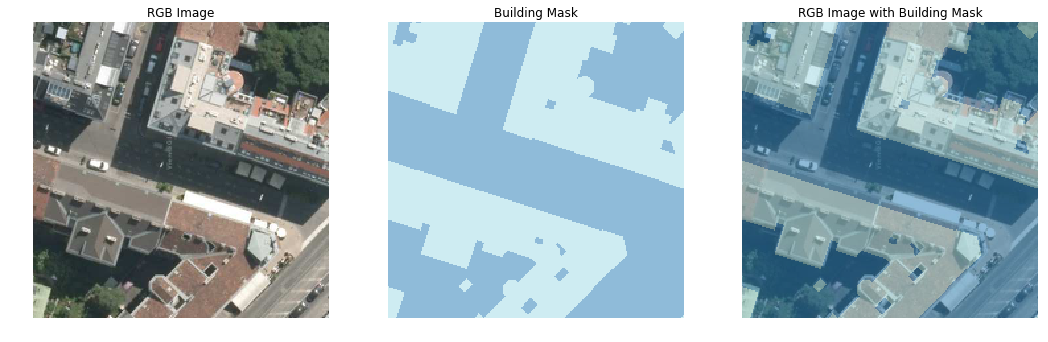

In [159]:
img_f = fnames[-1]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), div=True)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,6))

ax1.set_title('RGB Image')
img.show(ax=ax1)

ax2.set_title('Building Mask')
mask.show(ax=ax2)

ax3.set_title('RGB Image with Building Mask')
img.show(ax=ax3)
mask.show(ax=ax3)

> Here, the dataset used is made by combining satellite/aerial images and their corresponding mask images. Here, an RGB Image, the ground truth building mask and the mask overlaid on the RGB image is shown to describe the data.

In [12]:
src_size = np.array(mask.shape[1:])
print(src_size)
mask.data

[224 224]


tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 1],
         [1, 1, 1,  ..., 0, 1, 1]]])

> Here we can see that the mask is essentially a binary array comprising only of 0s and 1s, with 0 indicating that the pixel is not a building and 1 indicating that the pixel is a building. In this notebook, we are doing pixel-level analysis, so any pixel having more than 50% building coverage is labelled as 1 otherwise 0.

## 3. Making DataBunch

We will read all 8716 images and their corresponding masks into a single *DataBunch*. This is an object which we can initialize with parameters for train, test, split ratio and and ```__init__``` datatype. The *DataBunch* will be useful in accessing the data throughout the experiment in an efficient way.

### 3.1 Define Patch Size and Batch Size

In [13]:
size = 224
bs = 6

> Here, since we are building upon UNet, which uses a ResNet34/50 encoder with input tensor of size ```(244,244)```, we will set the patch size as 244. We will set the batch size as 6. This can later be changed depending on the availability of more memory. 

In [163]:
# class encoding
codes = np.array(['Empty','Building'])

### 3.2 Set Databunch Initialization Parameters

In [71]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True), probably a better way to do this? Currently no support
#available for PyTorch 1.5.0; can try updating to PyTorch 1.6.0
# This idea is taken from https://forums.fast.ai/t/unet-binary-segmentation/29833/40

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageImageList):
    _label_cls = SegLabelListCustom

In [72]:
src = (SegItemListCustom.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes))

> Here, we give refer the function```split_by_rand_pct()``` for creating a random split of the entire *DataBunch* at a random percentage each time this cell is run. To specify a seed percentage for splitting the data, please provide a keyword argument namely ```valid_pct``` indicating the percentage of validation data (ranges from 0 to 1). To use the entire *DataBunch* for training, use the function ```split_none()```.

### 3.3 Create DataBunch

In [73]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))

> **NOTE:** While creating the databunch, if running on windows, we need to set the ```num_workers = 0``` while creating a databunch. What this does is, while multiprocessing, the python kernel will not create any extra threads. This is because of certain administrative restrictions on Windows which prevents multi-threading and often results into a ```BrokenPipe Error```

### 3.4 Describing DataBunch

In [74]:
data

ImageDataBunch;

Train: LabelList (6973 items)
x: SegItemListCustom
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegLabelListCustom
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: data\images;

Valid: LabelList (1743 items)
x: SegItemListCustom
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegLabelListCustom
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: data\images;

Test: None

> Here, we can observe that the *DataBunch* has been split into train and test with roughly 7:3 ratio. The network will be trained on 6973 tiles and will be validated on 1743 tiles.

In [47]:
data.valid_ds.items

array([WindowsPath('data/images/grid_029_corrected_19_319453_270704_224_224_91_180_sw.png'),
       WindowsPath('data/images/grid_029_corrected_19_319456_270687_224_224_196_264_se.png'),
       WindowsPath('data/images/grid_001_19_319370_270504_224_224_112_287_se.png'),
       WindowsPath('data/images/grid_028_19_319425_270714_224_224_236_24_nw.png'), ...,
       WindowsPath('data/images/grid_029_corrected_19_319459_270683_224_224_201_182_sw.png'),
       WindowsPath('data/images/grid_049_19_319435_270815_224_224_79_186_se.png'),
       WindowsPath('data/images/grid_022_19_319401_270675_224_224_182_53_nw.png'),
       WindowsPath('data/images/23279140_15_224_224_1064_823_sw.png')], dtype=object)

In [48]:
 data.train_ds.x[1], data.train_ds.y[1]

(Image (3, 224, 224), ImageSegment (1, 224, 224))

> Here we can observe that the images have been reshaped according to the patch size of ```(224,224)```. Moreover, the training image comprises of 3 channels (RGB) while the mask image, or label, comprises of a single channel only since it is a binary image having pixel values as either 1 or 0 (See Section 2.2 for more).

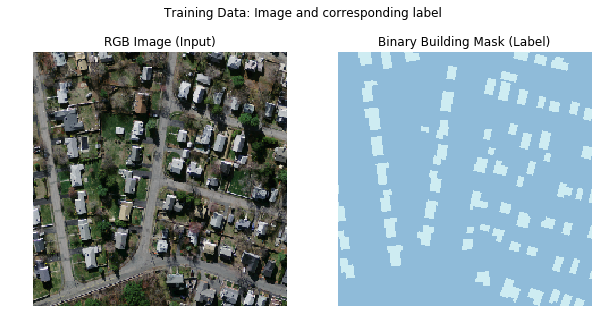

In [162]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Training Data: Image and corresponding label')
data.train_ds.x[1].show(ax=ax1)
ax1.set_title('RGB Image (Input)')

ax2.set_title('Binary Building Mask (Label)')
data.train_ds.y[1  ].show(ax=ax2)

In [51]:
data.train_ds.y[1].data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

#### 3.4.1 Describing Training Batch from *DataBunch*

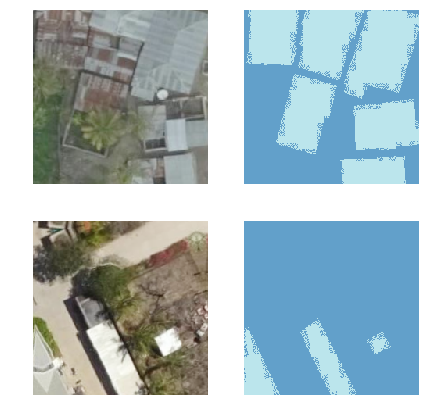

In [52]:
data.show_batch(2,figsize=(6,6), alpha=0.7)

#### 3.4.2 Describing Validation Batch from *DataBunch*

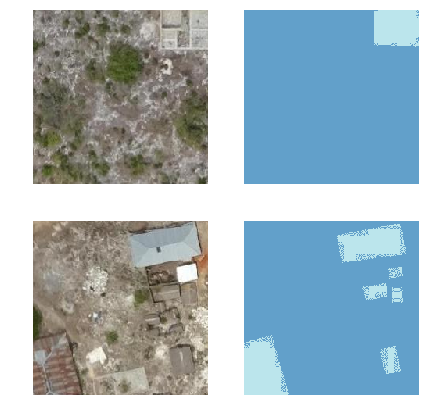

In [53]:
data.show_batch(2,figsize=(6,6), ds_type=DatasetType.Valid, alpha=0.7)

#### 3.4.3 Describing Classes

In [54]:
data.classes

array(['Empty', 'Building'], dtype='<U8')

## 4. Set Custom Loss as a Combination of Binary Cross Entropy Loss and Dice Loss

To train the model, we will use a custom loss which is a comnimation of:
* Dice Loss
The *Dice Loss* has been used to quantify the accuracy of the model in gauging the similarity of the predicted sample and the ground truth. It is similar to the *Intersection over Union (IoU)* metric, only it also accounts for crispness towards the edges/boundaries in the prediction.

* Binary Cross Entropy Loss
This is a loss based on the probability function. As the prediction probability diverges from the ground truth, this loss increases.

Here we have use a combination of these two losses to have composite model evaluation metrics, and also to be able to calculate the Macro-F1 score, which is obtained from the dice loss.

In [75]:
import pdb

In [76]:
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

## 5. Define Model

### 5.1 Set Model Parameters

In [57]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

### 5.2 Set Model Metrics

In [58]:
# iou = partial(dice, iou=True)
metrics = [dice_loss, accuracy_thresh, dice]

### 5.3 Initialize Learner with Dynamic UNet model available in FastAI

In [77]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

> Here, we are using UNet pretraind on ResNet34 model weights

In [78]:
learn.metrics = metrics

In [79]:
learn.metrics

[<function __main__.dice_loss>,
 <function fastai.metrics.accuracy_thresh>,
 <function fastai.metrics.dice>]

In [80]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [81]:
learn.loss_func = combo_loss
learn.loss_func

<function __main__.combo_loss>

### 5.4 Find Learning Rate
This is a unique feature of FastAI - it simulates the training process for number of iterations equal to the first epoch and plots a graph of loss v/s learning rate. We can then choose the learning rate where the loss is minimum.

In [64]:
learn.lr_find()

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


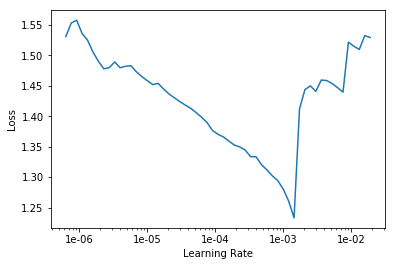

In [65]:
learn.recorder.plot()

> Based on the above graph, we can see that the loss troughs at ```lr = 1e-03```. So we will set that as the learning rate.

In [82]:
lr = 1e-03

### 5.5 Set up Custom Callbacks for best model while training
Here, we will override the ```SaveModelCallbackVerbose``` class to add the functionality of saving the model in an epoch if it is better than the one in the previous epoch, otherwise falling back to the one in the previous model.

In [67]:
from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

## 6. Training
We will initially train for 10 epochs keeping in mind the time constraint, and then we will retrain based on the accuracy. The retraining part is yet to be implemented, it will be in the next updated notebook. Here, we are using a uniqye methodology to train. We are using the concept of *Cyclic Learning Rates*. In this policy, the learning rate is not fixed during the entire training process, rather it will keep oscillating between a crest and a trough. This results into a dynamic network training which is faster than the traditional method of training neural networks. Another advantage of this dynamic method is that it fetches a very high accuracy in very less number of epochs. 

In [83]:
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                                 monitor='dice',
                                                 mode='max',
                                                 name='20190108-rn34unet-comboloss-alldata-512-best')
                    ]
                   )

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.481259,0.424323,0.264371,0.924775,0.708882,31:35
1,0.402037,0.362024,0.221544,0.947876,0.726956,30:41
2,0.349007,0.333044,0.203132,0.950047,0.745823,39:05
3,0.387137,0.335554,0.203812,0.952241,0.730351,53:56
4,0.333697,0.318722,0.194093,0.953064,0.752713,30:29
5,0.304901,0.304229,0.187755,0.952859,0.759499,27:15
6,0.305094,0.295474,0.179305,0.955766,0.764964,27:48
7,0.280898,0.276856,0.169680,0.958312,0.769877,27:25
8,0.275691,0.281631,0.170821,0.958870,0.766148,26:48
9,0.260946,0.278270,0.168156,0.959041,0.771428,29:45


Better model found at epoch 0 with dice value: 0.7088818550109863.
Better model found at epoch 1 with dice value: 0.7269558906555176.
Better model found at epoch 2 with dice value: 0.745823323726654.
Better model found at epoch 4 with dice value: 0.7527133226394653.
Better model found at epoch 5 with dice value: 0.7594985961914062.
Better model found at epoch 6 with dice value: 0.764963686466217.
Better model found at epoch 7 with dice value: 0.7698773741722107.
Better model found at epoch 9 with dice value: 0.7714284062385559.


> Here the accuracy right after the very first epoch is ~92% with a macro-F1 score of ~0.71. This is an evident advantage of the dynamic training method. Moreover, this is advantageous when we don't have a GPU or a high-end workstation to work with - ideally training to achieve such an accuracy would take upto 35-40 hours, but here we have the results within 6 hours, with roughly 35-40 minutes spent per epoch. Moreover, we have also implemented a *FallBack Provision*. What this does is, while training, if the model found at an epoch is not better than the one found at the previous epoch, it will immediately fall back to the one at the previous epoch. For eg: at epoch 3, a better model was not found than the one at epoch 2. So the saved model falls back to the one at epoch 2. Now, when the 4th epoch starts, weights from epoch 2 are modified and not epoch 3. 

>> Hence, with these integrations, the training process has been made much faster and much more accurate within a short period of time and a small number of epochs. Currently, after *10 epochs* and roughly *6 hours* of training, the results are as follows:
* Accuracy: **95.9%**
* Macro-F1 score: **0.77**

### 6.1 Model Architecture

In [84]:
learn.load('20190108-rn34unet-comboloss-alldata-512-best')
learn.model.train()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

### 6.2 Plotting Losses: Custom Loss (Section 4) per batches processed

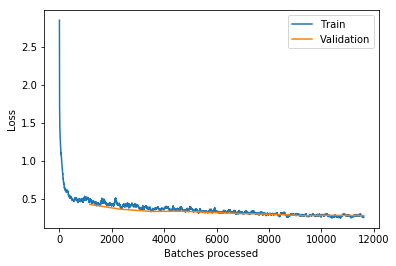

In [135]:
learn.recorder.plot_losses()

# 7. Evaluation

In [87]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)

In [88]:
outputs.shape

torch.Size([6, 2, 224, 224])

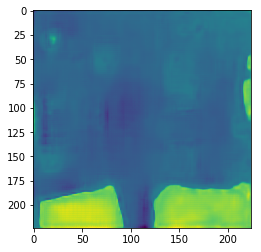

In [96]:
plt.imshow((outputs[1][1]).numpy())

In [97]:
outputs[2].shape

torch.Size([2, 224, 224])

### 7.1 Evaluating Model on Validation Dataset

In [265]:
from sklearn.metrics import jaccard_score as jsc

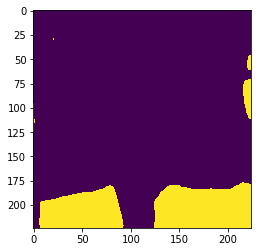

In [257]:
pred = to_np(outputs[1][1].sigmoid()>0.95)
plt.imshow(pred)

In [258]:
pred.shape

(224, 224)

In [291]:
gt = to_np(data.valid_ds.y[1])
gt.shape

(1, 224, 224)

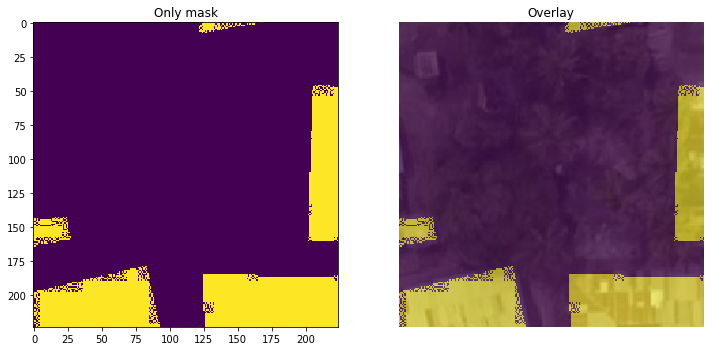

In [292]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.set_title('Only mask')
ax1.imshow(gt[0])

ax2.set_title('Overlay')
data.valid_ds.x[1].show(ax=ax2)
ax2.imshow(gt[0], alpha=0.6)

In [293]:
gt.shape

(1, 224, 224)

In [294]:
gt = np.array(gt[0], dtype=bool)

In [295]:
gt, pred

(array([[False, False, False, False, ..., False, False, False, False],
        [False, False, False, False, ..., False, False, False, False],
        [False, False, False, False, ..., False, False, False, False],
        [False, False, False, False, ..., False, False, False, False],
        ...,
        [ True, False,  True,  True, ...,  True,  True,  True,  True],
        [False,  True, False, False, ...,  True,  True,  True,  True],
        [ True, False,  True,  True, ...,  True,  True,  True,  True],
        [False, False,  True, False, ...,  True,  True,  True,  True]]),
 array([[False, False, False, False, ..., False, False, False, False],
        [False, False, False, False, ..., False, False, False, False],
        [False, False, False, False, ..., False, False, False, False],
        [False, False, False, False, ..., False, False, False, False],
        ...,
        [False, False, False, False, ...,  True,  True,  True,  True],
        [False, False, False, False, ...,  True, 

In [307]:
(gt | pred)

array([[False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False],
       ...,
       [ True, False,  True,  True, ...,  True,  True,  True,  True],
       [False,  True, False, False, ...,  True,  True,  True,  True],
       [ True, False,  True,  True, ...,  True,  True,  True,  True],
       [False, False,  True, False, ...,  True,  True,  True,  True]])

In [312]:
np.invert(gt | pred).sum()

40176

In [306]:
(gt & pred).sum()

6678

In [283]:
jsc(gt[0].reshape(-1), pred.reshape(-1))

0.6678

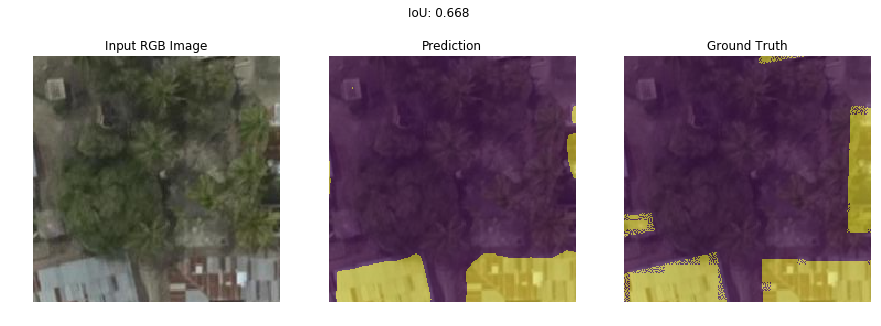

Accuracy:  0.934
Precision:  0.716
Recall:  0.908
Branching Factor:  0.101
Miss Factor:  0.396
Detection Percentage:  71.622
Quality Percentage:  66.78
                                               ************************                                               


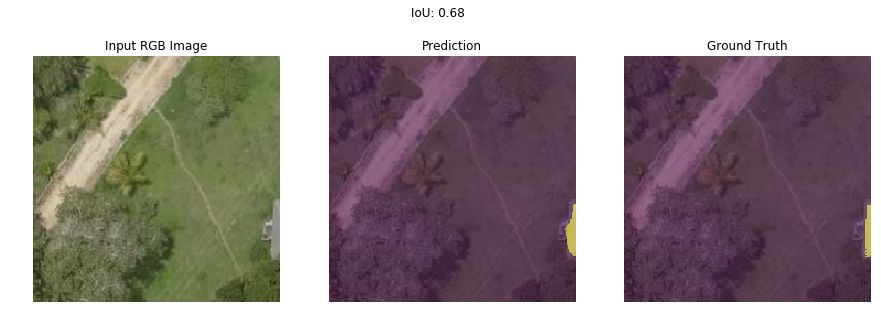

Accuracy:  0.998
Precision:  0.936
Recall:  0.713
Branching Factor:  0.403
Miss Factor:  0.068
Detection Percentage:  93.636
Quality Percentage:  67.987
                                               ************************                                               


E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in long_scalars
E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


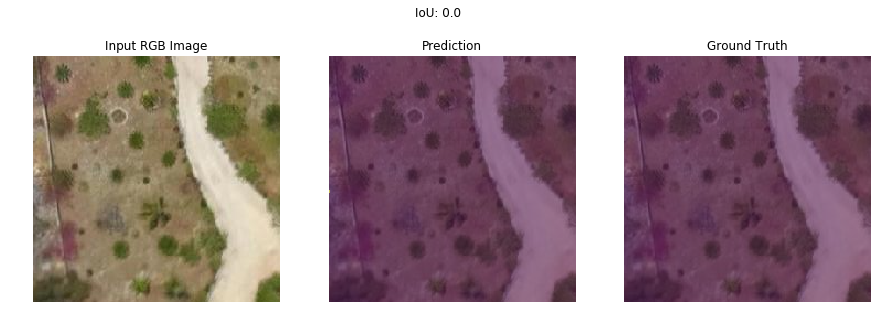

Accuracy:  1.0
Precision:  nan
Recall:  0.0
Branching Factor:  inf
Miss Factor:  nan
Detection Percentage:  nan
Quality Percentage:  0.0
                                               ************************                                               


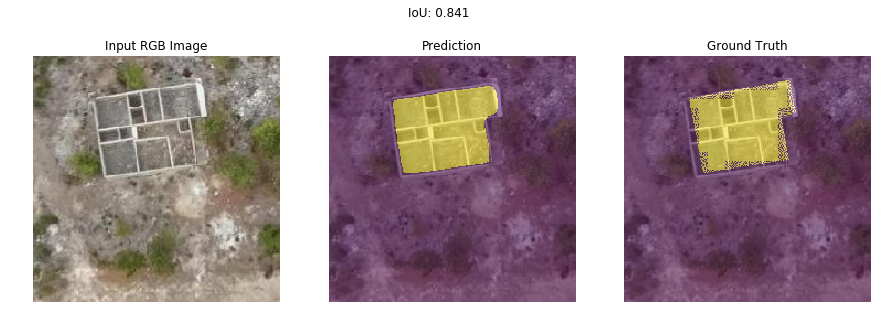

Accuracy:  0.981
Precision:  0.95
Recall:  0.88
Branching Factor:  0.137
Miss Factor:  0.052
Detection Percentage:  95.035
Quality Percentage:  84.107
                                               ************************                                               


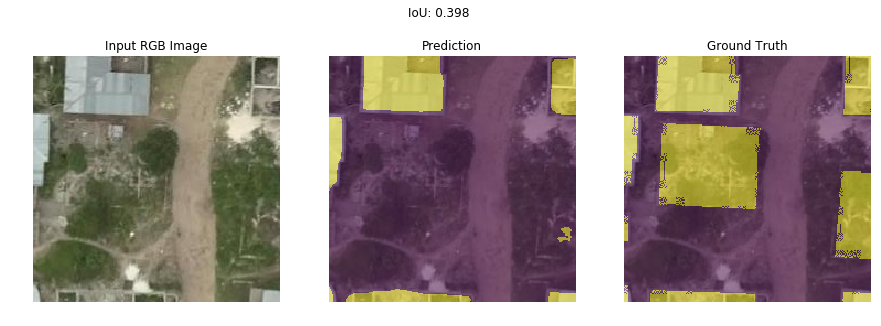

Accuracy:  0.815
Precision:  0.41
Recall:  0.934
Branching Factor:  0.07
Miss Factor:  1.441
Detection Percentage:  40.962
Quality Percentage:  39.818
                                               ************************                                               


In [318]:
for i in range(1,bs):
    # converting tensors to numpy arrays
    ground_truth = to_np(data.valid_ds.y[i])
    prediction = to_np(outputs[i][1].sigmoid()>0.95)
    
    # converting ground truth to binary/boolean arrays for calculating metrics
    gt = np.array(ground_truth[0], dtype=bool)
    # prediction is already a binary array
    
    #getting TP, TN, FP, FN
    TP = (gt & prediction).sum()
    TN = np.invert(gt | prediction).sum()
    FP = (prediction & np.invert(gt)).sum()
    FN = (np.invert(prediction) & gt).sum()
    
    # calculating metrics
    iou = jsc(ground_truth[0].reshape(-1), prediction.reshape(-1))
    branching_factor = FP/TP
    miss_factor = FN/TP
    detection_percentage = 100*(TP/(TP+FN))
    quality_percentage = 100*(TP/(TP+FP+FN))
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FN)
    recall = TP/(TP+FP)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
    
    fig.suptitle("IoU: " + str(round(iou, 3)))
    
    ax1.set_title('Input RGB Image')
    data.valid_ds.x[i].show(ax=ax1)
    
    ax2.set_title('Prediction')
    data.valid_ds.x[i].show(ax=ax2)
    ax2.imshow(prediction, alpha=0.5)
    
    ax3.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax3)
    ax3.imshow(ground_truth[0], alpha=0.5)
    plt.show()
    
    print("Accuracy: ", round(accuracy,3))
    print("Precision: ", round(precision,3))
    print("Recall: ", round(recall,3))
    print("Branching Factor: ", round(branching_factor,3))
    print("Miss Factor: ", round(miss_factor,3))
    print("Detection Percentage: ", round(detection_percentage,3))
    print("Quality Percentage: ", round(quality_percentage,3))
    print("************************".center(118))


### 7.2 Evaluating Model on Test Dataset

In [316]:
x = data.valid_ds.x[20]
y = data.valid_ds.y[20]
xp = learn.predict(x)

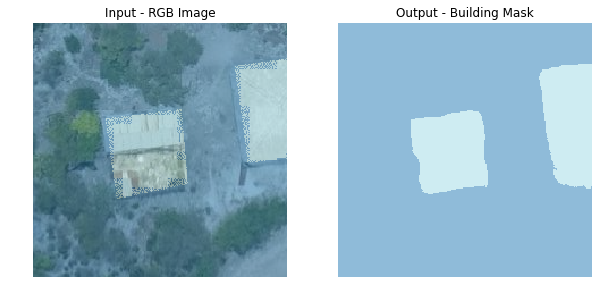

In [317]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

x.show(ax=ax1)
y.show(ax=ax1, alpha=0.5)
ax1.set_title('Input - RGB Image')

ax2.set_title('Output - Building Mask')
xp[0].show(ax=ax2)

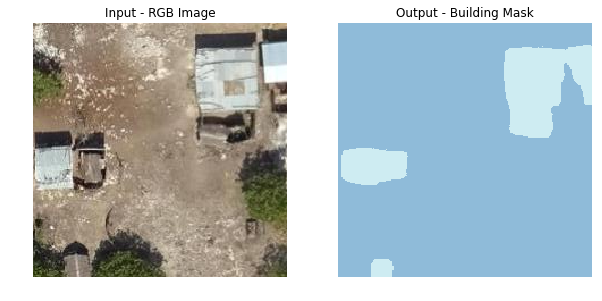

In [143]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

x.show(ax=ax1)
ax1.set_title('Input - RGB Image')

ax2.set_title('Output - Building Mask')
xp[0].show(ax=ax2)

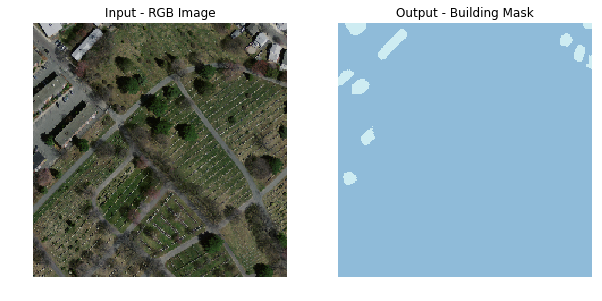

In [145]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

x.show(ax=ax1)
ax1.set_title('Input - RGB Image')

ax2.set_title('Output - Building Mask')
xp[0].show(ax=ax2)

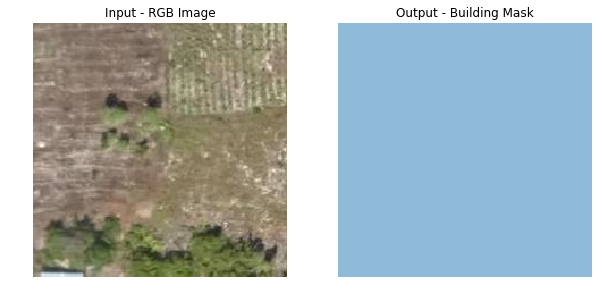

In [147]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

x.show(ax=ax1)
ax1.set_title('Input - RGB Image')

ax2.set_title('Output - Building Mask')
xp[0].show(ax=ax2)

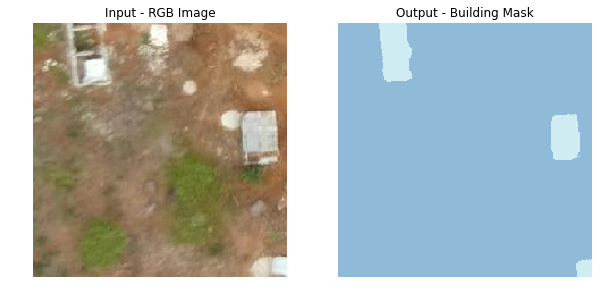

In [149]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

x.show(ax=ax1)
ax1.set_title('Input - RGB Image')

ax2.set_title('Output - Building Mask')
xp[0].show(ax=ax2)

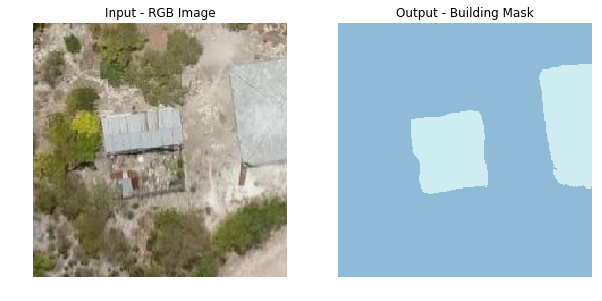

In [157]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

x.show(ax=ax1)
ax1.set_title('Input - RGB Image')

ax2.set_title('Output - Building Mask')
xp[0].show(ax=ax2)